In [1]:
%load_ext autoreload
%autoreload 2
import mantis_wave_modelling.model_building as manMB
import mantis_wave_modelling.wave_modelling as manWM
import mantis_wave_modelling.wavelet as manWLET
import mantis_core.utilities as manUTILS
import numpy as np

# Preliminary definitions: earth model, wavelet.

In [2]:
from wave_modelling_backend import generate_data as gd
data = gd.load_data_to_initial_model("./wave_modelling_backend/input.csv")

In [3]:
top_halfspace = manMB.IsotropicHalfspace(**data["top halfspace"])
reflection_zone = manMB.ReflectionZone(**data["reflection zone"])
bottom_halfspace = manMB.IsotropicHalfspace(**data["bottom halfspace"])
depth_intervals = np.append(.1, np.diff(data["Depth array"]))

In [4]:
sample_rate = 1000.0
n_samples = 2**11
angles = np.arange(0, 48, 3)
wavelet_frequency = 35
wavelet = manWLET.wavelet(identifier="ricker", central_frequency=wavelet_frequency)
balgonie_model = manMB.EarthModel(
    top_halfspace=top_halfspace,
    bottom_halfspace=bottom_halfspace,
    reflection_zone=reflection_zone,
    depth_array=depth_intervals,
)

# Elastic convolution with primaries

In [6]:

avo_modeller = manWM.ConvolutionalAVOGather(
    earth_model=balgonie_model, wavelet=wavelet, nSamples=n_samples, dt=1 / sample_rate
)
avo_gather = np.array([np.real(avo_modeller.time_avo(angle=a)[1]) for a in angles])

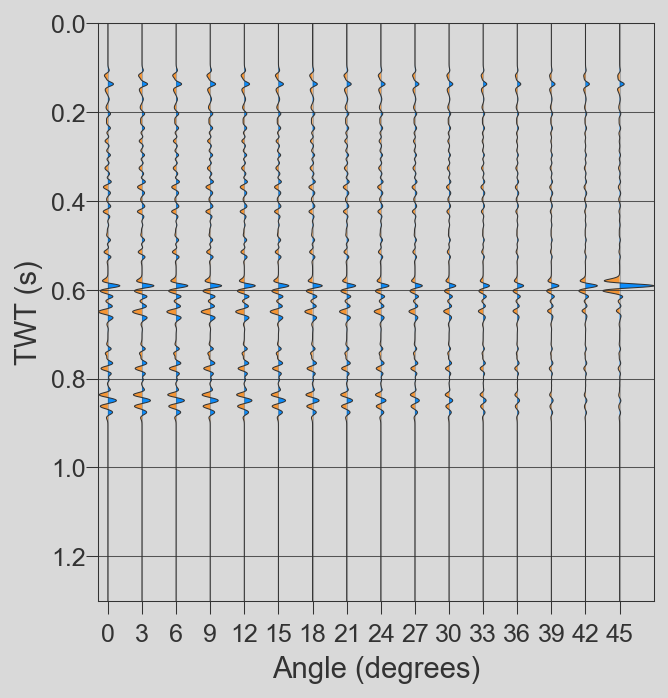

In [8]:
from wave_modelling_backend.generate_data import WigglePlot
import matplotlib.pyplot as plt
wiggle = WigglePlot(
    avo_modeller.time_axis, avo_gather.T
)
wiggle.exaggeration = 'normal'
wiggle.layout = "tight"
fig, ax = wiggle()
ax.set_ylim(0., 1.3)
xlabels = [f'{x:.0f}' for x in angles]
ax.set_xticks(np.arange(len(angles)+1)[1::], labels=xlabels)
ax.invert_yaxis()
ax.set_xlabel("Angle (degrees)")
ax.set_ylabel("TWT (s)")
plt.show()
plt.close()


# Viscoelastic convolution with primaries

# Multiples and reflectivity

In [9]:
multiples = manWM.ShotGather(
    earth_model=balgonie_model,
    wavelet=wavelet,
    receiver_coordinates=np.array([0.0, 0.0, 0.0]),
    nSamples=n_samples,
    dt=1 /sample_rate,
)

In [10]:
slownesses = manUTILS.incidence_angle_to_slowness(np.deg2rad(angles), top_halfspace.Vp)

In [12]:
avo_gather_multiples = np.array(
    [np.real(multiples.wavefield(horizontal_slowness=[slow, 0.001])) for slow in slownesses]
)

Text(0, 0.5, 'TWT (s)')

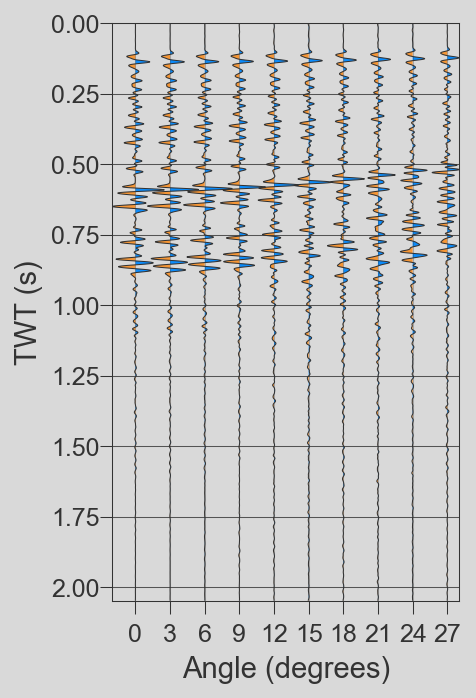

In [13]:
# from wave_modelling_backend.generate_data import WigglePlot

wiggle = WigglePlot(avo_modeller.time_axis, avo_gather_multiples[:10].T)
wiggle.exaggeration = "normal"
wiggle.layout = "tight"
fig, ax = wiggle()
# ax.set_ylim(0.0, 2.3)
xlabels = [f"{x:.0f}" for x in angles]
ax.set_xticks(np.arange(len(angles) + 1)[1:11], labels=xlabels[:10])
ax.invert_yaxis()
ax.set_xlabel("Angle (degrees)")
ax.set_ylabel("TWT (s)")

We can compare the convolution of the primaries with the convolution of the primaries and multiples at zero offset.

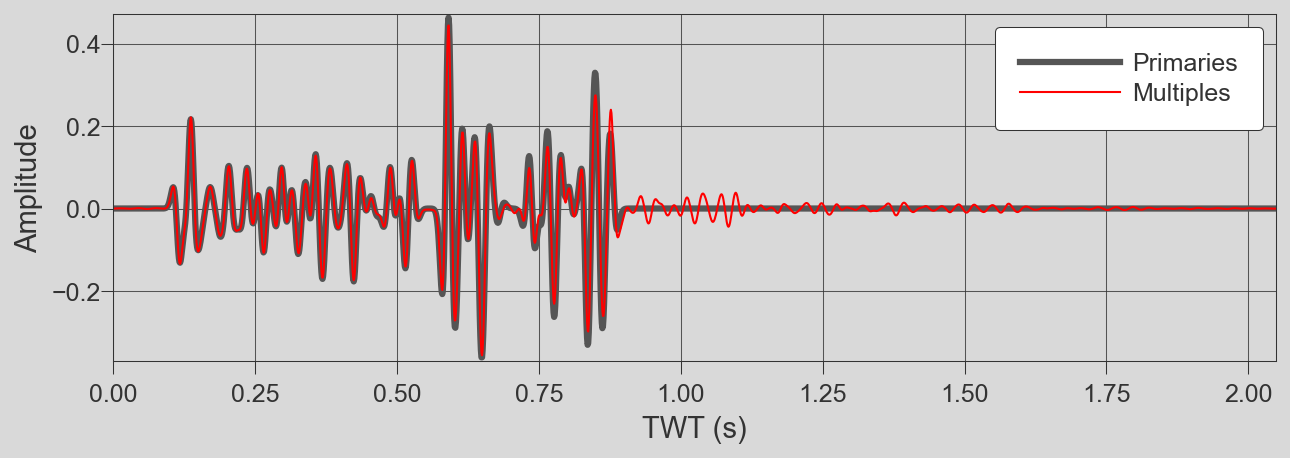

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(
    avo_modeller.time_axis,
    2 * avo_gather[0],
    linewidth=3,
    label="Primaries",
)
ax.plot(avo_modeller.time_axis, avo_gather_multiples[0], linewidth=1.,color='r', label="Multiples")
ax.legend()
ax.set_xlabel("TWT (s)")
ax.set_ylabel("Amplitude")
plt.show()